# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Project 2: To Bike or Not to Bike...

## Overview
Welcome to Project 2! This goal of this project is to take the EDA work you did in Project 1 and build the best linear regression model using the features you were given and any you have derived from them. 

In this project, you will practice and demonstrate the following skills:
- EDA (just a tad!)
- Feature Engineering
- Single Linear Regression
- Multiple Linear Regression
- Linear Regression Evaluation Metrics


## Getting Ready for Modelling

#### 1. Import Data from Project 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_style("whitegrid")

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold

In [2]:
bikes = pd.read_csv('data/bikes_modified.csv')

In [3]:
bikes.head()

,instant,dteday,holiday,weathersit,temp,atemp,hum,windspeed,count,day_of_the_week,month,season
0,1,2011-01-01,0,1,0.24,0.2879,0.81,0.0,16,Saturday,January,Winter
1,2,2011-01-01,0,1,0.22,0.2727,0.80,0.0,40,Saturday,January,Winter
2,3,2011-01-01,0,1,0.22,0.2727,0.80,0.0,32,Saturday,January,Winter
3,4,2011-01-01,0,1,0.24,0.2879,0.75,0.0,13,Saturday,January,Winter
4,5,2011-01-01,0,1,0.24,0.2879,0.75,0.0,1,Saturday,January,Winter


### On Second thought:
 - Created new df with daily values

In [4]:
bikes_daily = pd.DataFrame(bikes.groupby(['dteday'], as_index=False).sum())
bikes_daily.head()

,dteday,instant,holiday,weathersit,temp,atemp,hum,windspeed,count
0,2011-01-01,300,0,38,8.26,8.7270,19.34,3.8507,985
1,2011-01-02,828,0,45,8.36,8.1360,16.01,5.7164,801
2,2011-01-03,1287,0,22,4.32,4.1669,9.62,5.4628,1349
3,2011-01-04,1863,0,24,4.60,4.8788,13.58,3.6868,1562
4,2011-01-05,2392,0,23,5.22,5.2732,10.05,4.2987,1600


 - Dropped instant and weathersit columns, because they were not 'summable' values.

In [5]:
bikes_daily.drop(columns = ['instant', 'weathersit'], inplace = True)
bikes_daily.head()

,dteday,holiday,temp,atemp,hum,windspeed,count
0,2011-01-01,0,8.26,8.7270,19.34,3.8507,985
1,2011-01-02,0,8.36,8.1360,16.01,5.7164,801
2,2011-01-03,0,4.32,4.1669,9.62,5.4628,1349
3,2011-01-04,0,4.60,4.8788,13.58,3.6868,1562
4,2011-01-05,0,5.22,5.2732,10.05,4.2987,1600


- New Column with weather_sit, half values present we will assume that it is between (not ideal) 

In [6]:
bikes_daily['weather_sit'] = bikes.groupby(['dteday'])['weathersit'].transform('median')
bikes_daily.head()

,dteday,holiday,temp,atemp,hum,windspeed,count,weather_sit
0,2011-01-01,0,8.26,8.7270,19.34,3.8507,985,1.5
1,2011-01-02,0,8.36,8.1360,16.01,5.7164,801,1.5
2,2011-01-03,0,4.32,4.1669,9.62,5.4628,1349,1.5
3,2011-01-04,0,4.60,4.8788,13.58,3.6868,1562,1.5
4,2011-01-05,0,5.22,5.2732,10.05,4.2987,1600,1.5


In [7]:
# checking dtypes dteday went back to object
bikes_daily['dteday'] = pd.to_datetime(bikes_daily['dteday']);

#### 2. Create Data Dictionary

Write a data dictionary in a markdown table below. For variables that were found in the original dataset for Project 1, you can use the description that came with the dataset.

<h1><center>Column descriptions</center></h1>

|Column| Description|
|---|---|
|**instant**| **Record index** |
|**dteday**| **Date** |
|**holiday**| **Indicator if day is a holiday** |
|**weather_sit**| **Weather Situation -- half values are somewhere in between**|
   | | 1: Clear, Few   clouds, Partly cloudy, Partly cloudy 
   | | 2: Mist + Cloudy, Mist + Broken clouds,   Mist + Few clouds, Mist
   | | 3: Light Snow, Light Rain + Thunderstorm + Scattered   clouds, Light Rain + Scattered clouds
   | | 4: Heavy Rain + Ice Pallets +   Thunderstorm + Mist, Snow + Fog) |
|**temp**|**Normalized - temperature in Fahrenheit** | 
   | | The values are derived via (t-t_min)/(t_max-t_min),   t_min=-8, t_max=+39 |
|**atemp***|**Normalized - Feeling temperature in Celsius**
   | | The values are derived via   (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale) |
   |**hum***| **Normalized humidity**
   | |    The values are divided to 100 (max)|
| **windspeed**| **Normalized wind speed**
   | | The values are divided to 67 (max) |
|**count**| **Count of total rental bikes** |
|**DAY COLUMNS**| **Mon Tues Wed Thur Fri Sat Sun** |
   | | Columns based off of day_of_the_week  |
   | |  |
   | |**PREVIOUS DATASET ONLY**  |
   | |  |   
|**day_of_the_week**| **Day of the Week** |  
|**month**| **Month** |
|**season**| **Season** |
   | | December, January, February = Winter |
   | | March, April, May = Spring |
   | | June, July, August = Summer |
   | | September, October, November = Fall |

#### 3. Short EDA

##### 3.A Check for Multicollinearity
Using your choice of data visualization, explore the relationship between all of the feature variables to check for multicollinearity.

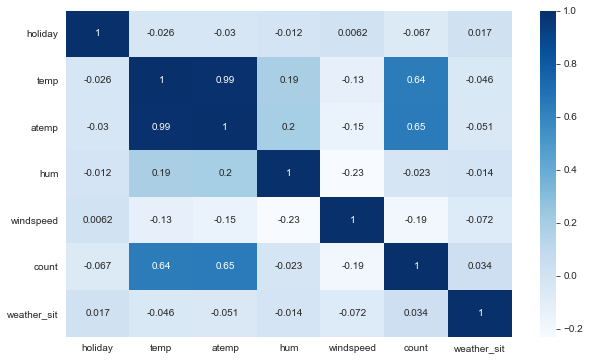

In [8]:
plt.figure(figsize=(10,6));
sns.heatmap(bikes_daily.corr(), annot=True, cmap='Blues');
plt.yticks(rotation=0);

## Not adding day of week dummies to this heat map, becomes too busy

- High corrolation between temp and atemp, so I will continue to use temp only.
    - I conclude that they give almost the same information so multicollinearity really occurs in temp and atemp
- Next closest corrolation is Weather Situation and Humidity
- Count and temp/atemp 

- Dummy Columns for day of the week

In [9]:
bikes_daily['day_of_the_week'] = bikes_daily['dteday'].dt.day_name(); # creating weekday name column
bikes_daily = pd.get_dummies(bikes_daily, columns=['day_of_the_week']) # creating dummies columns
bikes_daily.rename(columns={'day_of_the_week_Monday': 'Mon', 
                            'day_of_the_week_Tuesday': 'Tue',
                            'day_of_the_week_Wednesday': 'Wed',
                            'day_of_the_week_Thursday': 'Thu',
                            'day_of_the_week_Friday': 'Fri',
                            'day_of_the_week_Saturday': 'Sat',
                            'day_of_the_week_Sunday': 'Sun',
                           }, inplace=True) #renaming dummy columns
bikes_daily.head()

,dteday,holiday,temp,atemp,hum,windspeed,count,weather_sit,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,2011-01-01,0,8.26,8.7270,19.34,3.8507,985,1.5,0,0,1,0,0,0,0
1,2011-01-02,0,8.36,8.1360,16.01,5.7164,801,1.5,0,0,0,1,0,0,0
2,2011-01-03,0,4.32,4.1669,9.62,5.4628,1349,1.5,0,1,0,0,0,0,0
3,2011-01-04,0,4.60,4.8788,13.58,3.6868,1562,1.5,0,0,0,0,0,1,0
4,2011-01-05,0,5.22,5.2732,10.05,4.2987,1600,1.5,0,0,0,0,0,0,1


##### 3.B Relationship Between Features and Target Variable
Using your choice of data visualization, explore the relationship between each of your feature variables and your target variable.

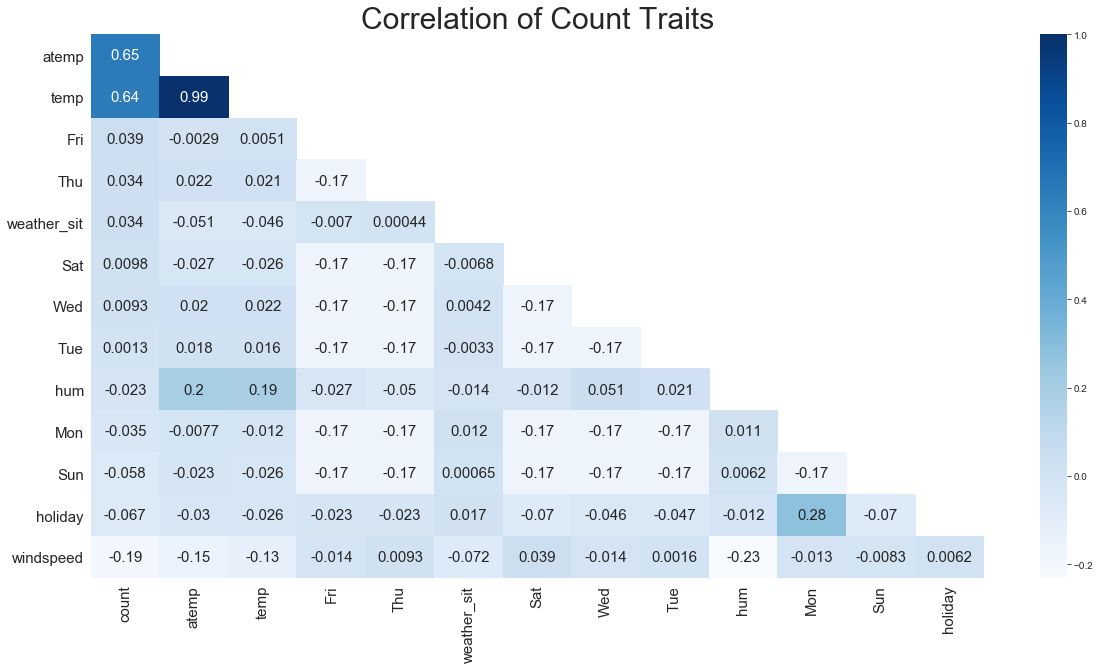

In [10]:
## Code posted by John Hazard

fig = plt.figure(figsize= (20,10)) 
mask = np.triu(np.ones_like(bikes_daily.corr()))
col_order = bikes_daily.corr().sort_values('count', ascending=False).index
ax = sns.heatmap(bikes_daily[col_order].corr(), 
                 annot= True,annot_kws={"size":15},
                 mask= mask,
                 cmap='Blues')
ax.set_title('Correlation of Count Traits', fontsize=30)
ax.tick_params(axis='x', labelsize=15, labelrotation=90)
ax.tick_params(axis='y', labelsize=15, labelrotation=0)
y_min, y_max = ax.get_ylim()
x_min, x_max = ax.get_xlim()
ax.set_ylim(top=y_max+1)
ax.set_xlim(right=x_max-1);

##### 3.C Pick a Single Predictor
Based on your findings in 3.B, what variable do you think would be most effective as the only feature in a Simple Linear Regression. Explain your reasoning.

    - Humidity has a strong negative corrolation to count
    - Temp is the strongest positive corrolation to count


### Simple Linear Regression

#### 1. Build a function that takes in two lists, Y and X, and returns the intercept and slope coefficients that minimize SSE/RSS. 

In [11]:
# def int_slope(X, y):
#     mean_yhat = bikes_daily[y].mean()
#     return np.sum(np.square(bikes_daily[y] -  mean_yhat))    ## initial was mean_yhat

def int_slope(x,y):
    y_bar = bikes_daily[y].mean()
    x_bar = bikes_daily[x].mean()
    
    std_y = np.std(bikes_daily[y], ddof=1)
    std_x = np.std(bikes_daily[x], ddof=1)
    r_xy = bikes_daily.corr().loc[x, y]
    
    beta_1 = r_xy * std_y / std_x # 1 unit increase ## slope coefficient
    beta_0 = y_bar - beta_1 * x_bar # intercept
    bikes_daily['yhat'] = round(beta_0 + beta_1 * bikes_daily[x],4) #line of best fit
    print(f'Intercept: {beta_0} \n Slope: {beta_1}')
   

#### 2. Use your function above to find the optimal slope and intercept between our Y value and the predictor you chose in 3.C above. Interpret the slope in real-world meaning.

In [12]:
int_slope('temp', 'count')

Intercept: 1206.6838147542794 
 Slope: 279.09622067196096


A 1 unit change in temperature is equal to 279 additional bikes being used on average

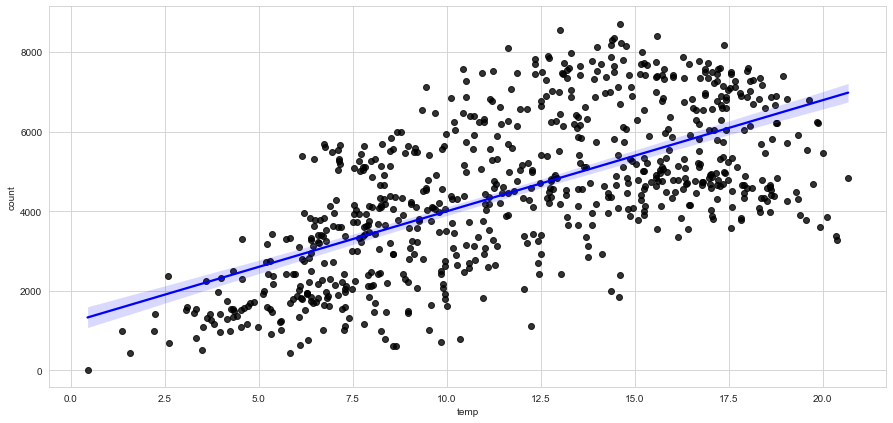

In [13]:
# create a figure
fig = plt.figure(figsize=(15,7))
# getting the figure axis
ax = plt.gca()

# plot a scatter plot with our data
sns.regplot(bikes_daily['temp'], bikes_daily['count'], scatter_kws={"color": "black"}, line_kws={"color": "blue"}); 
# color change code found on stackoverflow 'Different colors for points and line in Seaborn regplot' - DavidG


What I see from this is that, the warmer it got the more likely that the bikes were used,
however after about 18°C requests started going down as it got too hot

#### 3. Build a function that takes in a list of predictions and a corresponding list of observed values and then prints the following metrics: mean squared error, root mean squared error, R^2.

In [14]:
  
    ### UGH James said we should add manual calculation rather than use sklearn within the function....
    ## I'm glad for it because wow did I ever mess up...
    
def pred_corr(y, pred):
        print('MSE: ', ((pred - y)**2).mean()) # Goal to get MSE s close to 0 as possible
        print('RMSE: ', (((pred - y)**2).mean()**.5))
        print('R^2: ', (1 -(((y - pred)**2).sum()) / (((y - np.mean(y))**2).sum()))) # 1-sse/sst
        
#     print('MSE:', mean_squared_error(y, yhat))
#     print('RMSE:', np.sqrt(mean_squared_error(y, yhat)))
#     print('R2:',r2_score(y, yhat))
    
    

#### 4. Use the values you found in Problem 2 to calculate predictions for all values of X in your dataset. Then use the function from Problem 3 to report your evaluation metrics.

In [15]:
# Picking my X and y, I want to predict count off of temperature
X = bikes_daily[['temp']]
y = bikes_daily['count']

ls = LinearRegression()  # instantiating the model
model = ls.fit(X,y) # fitting the model
yhat = model.predict(X) # starting our predictions

In [16]:
# I want to check the coef_ & intercept_ to also verify that fist fucntion was correct
print(model.intercept_)
print(model.coef_)

1206.6838147542853
[279.09622067]


In [17]:
pred_corr(y, yhat)

MSE:  2199718.4513362097
RMSE:  1483.1447843471688
R^2:  0.413041279701975


In [18]:
# verifying values with 
print('MSE:', mean_squared_error(y, yhat)),
print('RMSE:', np.sqrt(mean_squared_error(y,yhat))),
print('R2:',r2_score(y, yhat))

MSE: 2199718.451336209
RMSE: 1483.1447843471685
R2: 0.413041279701975


In [19]:
bikes_daily.head()

,dteday,holiday,temp,atemp,hum,windspeed,count,weather_sit,Fri,Mon,Sat,Sun,Thu,Tue,Wed,yhat
0,2011-01-01,0,8.26,8.7270,19.34,3.8507,985,1.5,0,0,1,0,0,0,0,3512.0186
1,2011-01-02,0,8.36,8.1360,16.01,5.7164,801,1.5,0,0,0,1,0,0,0,3539.9282
2,2011-01-03,0,4.32,4.1669,9.62,5.4628,1349,1.5,0,1,0,0,0,0,0,2412.3795
3,2011-01-04,0,4.60,4.8788,13.58,3.6868,1562,1.5,0,0,0,0,0,1,0,2490.5264
4,2011-01-05,0,5.22,5.2732,10.05,4.2987,1600,1.5,0,0,0,0,0,0,1,2663.5661


### Multiple Linear Regression

#### 1. Set values of X and y, now using multiple features to build X.

In [20]:
X = bikes_daily.loc[:,['temp', 'hum', 'windspeed', 'weather_sit']].values
y = bikes_daily['count'].values  # use .values to make then Numpy arrays

In [21]:
bikes_daily.shape # since I have remade the df to daily counts, there are alot less rows

(731, 16)

#### 2. Split  your data into train and test data. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30, random_state=42)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape #checking the size of my split

((511, 4), (220, 4), (511,), (220,))

#### 3. Use sklearn to fit a linear regression model between your X and y

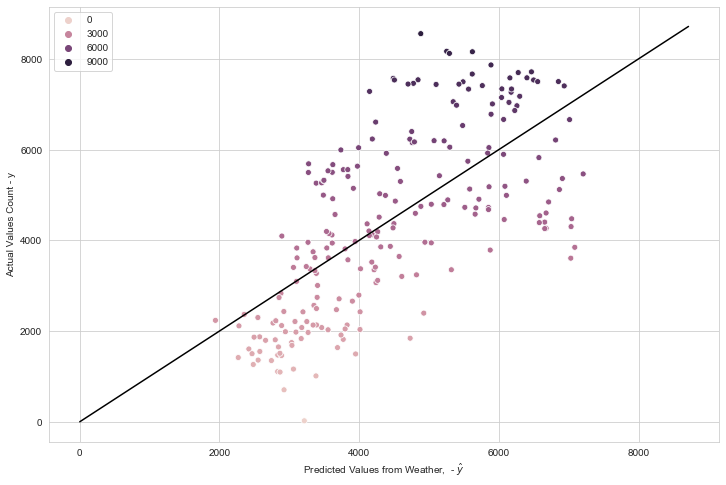

In [24]:
#instantiate model
lr = LinearRegression()
 
#fit model
model = lr.fit(X_train, y_train)
 
#generate predictions
y_pred = model.predict(X_test)
 
# Plot the model
plt.figure(figsize=(12,8))
sns.scatterplot(y_pred, y_test, hue = y_test,)
plt.xlabel("Predicted Values from Weather,  - $\hat{y}$")
plt.ylabel("Actual Values Count - y")
plt.plot([0, np.max(y)], [0, np.max(y)], c = 'k')
plt.show()

#### 4. Use your function from the previous section to evaluate your model for both your training and testing data. What does the difference between these values tell you about your model? (Hint: Consider the bias-variance tradeoff)

In [25]:
# Eval for testing data
test_pred = model.predict(X_test)
pred_corr(y_test, y_pred)

MSE:  2137839.8140817676
RMSE:  1462.1353610667404
R^2:  0.46271474227568454


In [26]:
# Eval for training data as you requested
# however you never predict off of train
train_pred = model.predict(X_train)
pred_corr(y_train, train_pred)

MSE:  2001379.822808901
RMSE:  1414.7013192928396
R^2:  0.45000471947474563


In [27]:
# Checking how we are performing
print(lr.score(X_test, y_test))
print(lr.score(X_train, y_train))

0.46271474227568454
0.45000471947474563


- High Biased Model, underfitted
- Scoring is low which indicates that it is not a good model
- Reducing the columns to show daily, also reduced the amount of data to train / test off of

#### 5. Based on your MLR model from above, choose two X features and interpret their real-world meaning. If you used a dummy variable, please make that one of your options. coef_ ?


-  The Warmer the weather got the more likely to ride a bike
 -  Less Humidity = More likely to ride a bike


#### 6. Plot the residual values of your model. Based on your graph and information from your earlier EDA, does your model satisfy the LINEI Assumptions for MLR models? (*Support your answer*)

In [28]:
# find residuals
bikes_daily['residuals'] = bikes_daily['count'] - bikes_daily['yhat']


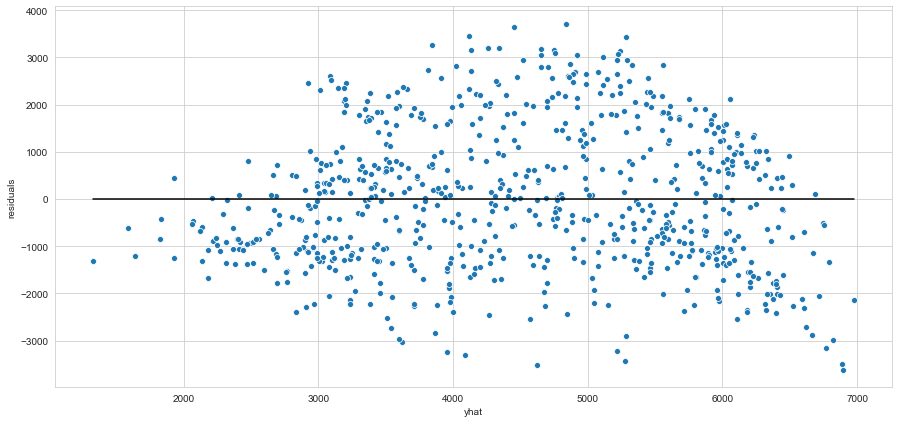

In [29]:
fig = plt.figure(figsize=(15,7))
ax = plt.gca()

sns.scatterplot(bikes_daily['yhat'], bikes_daily['residuals'],)

ax.plot((bikes_daily['yhat'].min(), bikes_daily['yhat'].max()), (0,0), color = 'k');

There are a few outliers in my Residuals plot, variance is roughly the same, and seem to be independent of one another

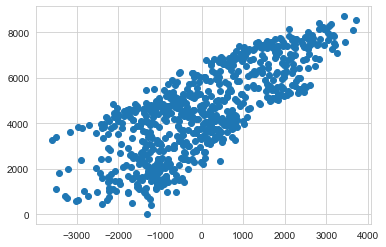

In [30]:
# I assumption
plt.scatter(bikes_daily['residuals'], y)

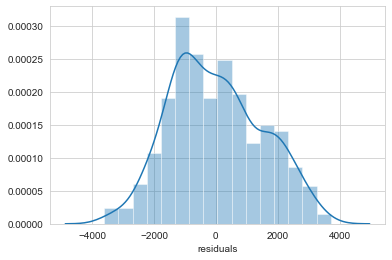

In [31]:
# N assumption
sns.distplot(bikes_daily['residuals'])

Residuals are fairly normalized, with a slight right skew

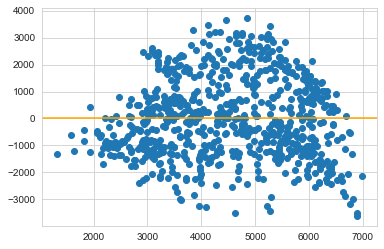

In [32]:
 # L & E assumption
plt.scatter(bikes_daily['yhat'], bikes_daily['residuals'])
plt.axhline(0, color = 'orange'); 

## Try try again
The best way to make a good model is to try a lot of things! Circle back to your workflow above and try different combinations of variables. In the cell below, explain what other versions of the model you ran and what set of features was the best fit. Why do you think that version was strongest?

In [33]:
# Try with day of the week dummies
X = bikes_daily.loc[:,['temp', 'hum', 'windspeed', 'weather_sit', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].values
y = bikes_daily['count'].values  # use .values to make then Numpy arrays

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30, random_state=42)

#instantiate model
lr = LinearRegression()
 
#fit model
model = lr.fit(X_train, y_train)
 
#generate predictions
y_pred = model.predict(X_test)
pred_corr(y_test, y_pred)

print(lr.score(X_train, y_train))


MSE:  2141261.7118864423
RMSE:  1463.3050645324927
R^2:  0.46185474554824935
0.4545067703872686


 No improvement from above MLR test, adding days of the week slightly reduces the scores, days only makes it worse

 
|      | Weather Only | All | Days Only|
|------|------|------|------|
|   MSE| 2137839.8140817676|  2141261.7118864423| 4045869.190909091|
|RMSE|1462.1353610667404|  1463.3050645324927| 2011.4346101499523|
|   R²| 0.46271474227568454|  0.46185474554824935| -0.01681419563707154|
|   Train Score| 0.45000471947474563|  0.4545067703872686| 0.009813871811450103|

In [34]:
# Try with day of the week dummies
X = bikes_daily.loc[:,['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].values
y = bikes_daily['count'].values  # use .values to make then Numpy arrays

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.30, random_state=42)

#instantiate model
lr = LinearRegression()
 
#fit model
model = lr.fit(X_train, y_train)
 
#generate predictions
y_pred = model.predict(X_test)
pred_corr(y_test, y_pred)

print(lr.score(X_train, y_train))

## Woah that's horrible

MSE:  4045869.190909091
RMSE:  2011.4346101499523
R^2:  -0.01681419563707154
0.009813871811450103


###  Try With Humidity

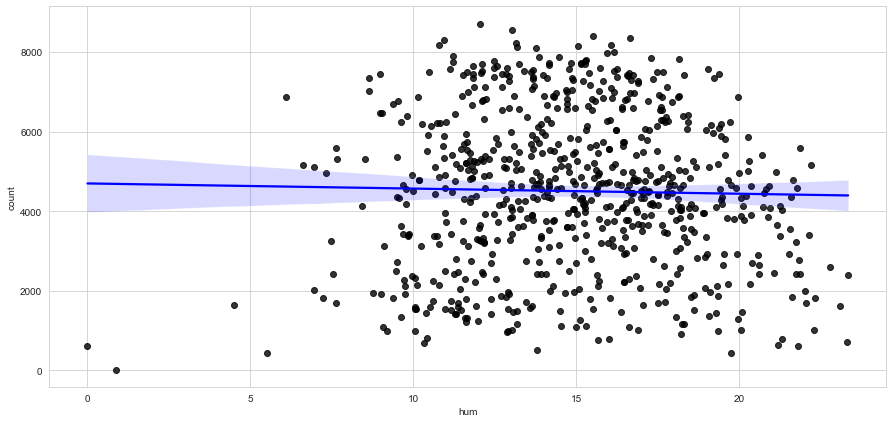

In [35]:
# create a figure
fig = plt.figure(figsize=(15,7))
# getting the figure axis
ax = plt.gca()

# plot a scatter plot with our data
sns.regplot(bikes_daily['hum'], bikes_daily['count'], scatter_kws={"color": "black"}, line_kws={"color": "blue"}); 
# color change code found on stackoverflow 'Different colors for points and line in Seaborn regplot' - DavidG


In [36]:
# Picking my X and y, I want to predict count off of temperature
X = bikes_daily[['hum']]
y = bikes_daily['count']

ls = LinearRegression()  # instantiating the model
model = ls.fit(X,y) # fitting the model
yhat = model.predict(X) # starting our predictions

pred_corr(y, yhat)
print(model.coef_)
print(ls.score(X, y))


MSE:  3745655.194411792
RMSE:  1935.369523995816
R^2:  0.0005334645194713383
[-12.91835594]
0.0005334645194713383


- Humidity compared to Temperature against count did much worse, which isnt surprising as Humidity is very strongly negatively corroletated to Count. For every unit change in humidity there is 12 less requests for bicylcles on average
 
|      | Temp | Hum| 
|------|------|------|
|   MSE| 2199718.4513362097|  3745655.194411792|
|RMSE|1483.1447843471688|  1935.369523995816|
|   R²| 0.413041279701975|  0.0005334645194713383| 
|Score|0.4130412797019751| 0.0005334645194713383|


In conclusion, the best model I currently have to work with is temp / count. Will need some additional finagling to make it better
as it currently stands I believe that the model is underfitted.